# COVID-19 and Weather Patterns

## Imports

- *os* for interfacing with the operating system
- *pathlib* for interfacing with the file system
- *zipfile* for managing archive files

- *numpy* for array processing
- *pandas* for tabular processing
- *tensorflow* for tensor processing
- *keras* for simplified tensor processing

- *matplotlib* for visualization
- *seaborn* for enhanced visualization

In [2]:
# Custom
import data_processing

# File System
import os
import json
from pathlib import Path
from zipfile import ZipFile

# Processing
import numpy as np
import pandas as pd
from sympy import *
from sympy.geometry import *
import tensorflow
from tensorflow import keras

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

tensorflow.__version__

'2.7.0'

## Introduction

The goal of this work is to determine whether or not weather patterns should be considered as a meaningful supporting input when making predictions about new daily COVID-19 cases within a given geographical space. Using census, weather, and COVID-19 datasets provided by the Urban Sustain project, the authors attempt to quantify the correlation between particular weather patterns and COVID-19 transmission events.

## Defining Terms

***Urban Sustain Project*** - A joint effort between researchers at Colorado State University, Arizona State University, the University of California-Irvine, and the University of Maryland – Baltimore County.

## Loading Data

**DEVELOPER NOTE:** Download the five required datasets from Urban Sustain and place them in the cloned repository at ```./data/```. These datasets are also available at a shared OneDrive folder. This logic expects that these files exist at relative path ```../data/``` with respect to this notebook.

We'll begin by defining a path to our data directory and a list of the datasets that we expect to find there.

In [30]:
DATA_PATH = '../data/' # Point this constant to the location of your data archive files

EXPECTED_DATASETS = [
    'county_total_population.Colorado.zip',
    'covid_county.Colorado.zip',
    'neon_2d_wind.Colorado.zip',
    'neon_barometric_pressure.Colorado.zip',
    'neon_single_asp_air_temperature.Colorado.zip'
]

Next, we will attempt to extract each of these archived datasets into a dedicated subdirectory within the given data directory.

In [31]:
# For each listed dataset string in the EXPECTED_DATASETS constant
for datasetName in EXPECTED_DATASETS:
    try:
        # Open the given archive file
        with ZipFile(DATA_PATH + datasetName, 'r') as currentZip:
            # Build the target directory path for extracted data
            datasetNameTokens = datasetName.split('.')
            datasetNameTokens.remove('zip')
            targetDirectory = DATA_PATH + '.'.join(datasetNameTokens)
            
            # If the target directory doesn't exist, create it
            if not os.path.exists(targetDirectory):
                Path(targetDirectory).mkdir()
            
            # Extract all data from the archive file to the target directory
            currentZip.extractall(targetDirectory)
    except FileNotFoundError:
        print("Unable to open " + datasetName + " at path " + DATA_PATH + datasetName)

## File Information

Four of the five datasets referenced in this work relate geospatial information to particular events as they occur over time Each is provided by the Urban Sustain project and employs a similar file structure.

- data.json
- fieldLabels.json
- linkedGeometry.json
- README.txt


#### New York Times COVID-19 County Dataset

The included COVID-19 County dataset 

In [32]:
covidDataFrame = pd.io.json.read_json('../data/covid_county.Colorado/data.json')
covidDataFrame.sample(5)

,_id,GISJOIN,epoch_time,dateString,county,state,totalCaseCount,newCaseCount,totalDeathCount,newDeathCount
4917,{'$oid': '615fc624bf06594c4cad5541'},G0800140,{'$numberLong': '1619935200000'},5/2/21,Broomfield,Colorado,4690,3,75,0
15987,{'$oid': '615fc625bf06594c4cad7f79'},G0800490,{'$numberLong': '1582873200000'},2/28/20,Grand,Colorado,0,0,0,0
35639,{'$oid': '615fc628bf06594c4cadd131'},G0801130,{'$numberLong': '1611385200000'},1/23/21,San Miguel,Colorado,594,11,0,0
3077,{'$oid': '615fc624bf06594c4cad4ddd'},G0800090,{'$numberLong': '1617775200000'},4/7/21,Baca,Colorado,278,0,4,0
35636,{'$oid': '615fc628bf06594c4cadd0ee'},G0801130,{'$numberLong': '1605423600000'},11/15/20,San Miguel,Colorado,163,8,0,0


In [33]:
covidLabelsFrame = pd.io.json.read_json('../data/covid_county.Colorado/fieldLabels.json')
covidLabelsFrame.sample(5)

,name,label
3,newCaseCount,New Case Count
4,totalCaseCount,Total Case Count
0,epoch_time,Date
1,newDeathCount,New Death Count
2,totalDeathCount,Total Death Count


In [34]:
covidGeometryFrame = pd.io.json.read_json('../data/covid_county.Colorado/linkedGeometry.json')
covidGeometryFrame.sample(5)

,_id,type,geometry,properties,GISJOIN
20,{'$oid': '604964ecfed2e95d6b68b673'},Feature,"{'type': 'Polygon', 'coordinates': [[[-103.714...","{'STATEFP10': '08', 'COUNTYFP10': '039', 'COUN...",G0800390
39,{'$oid': '604964eefed2e95d6b68b83c'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.430...","{'STATEFP10': '08', 'COUNTYFP10': '077', 'COUN...",G0800770
42,{'$oid': '604964ecfed2e95d6b68b685'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.970...","{'STATEFP10': '08', 'COUNTYFP10': '083', 'COUN...",G0800830
33,{'$oid': '604964ecfed2e95d6b68b67b'},Feature,"{'type': 'Polygon', 'coordinates': [[[-106.206...","{'STATEFP10': '08', 'COUNTYFP10': '065', 'COUN...",G0800650
58,{'$oid': '604964ecfed2e95d6b68b67e'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.621...","{'STATEFP10': '08', 'COUNTYFP10': '115', 'COUN...",G0801150


#### NEON 2D Wind Dataset

In [35]:
windDataFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/data.json')
windDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,windSpeedMean,windSpeedMinimum,windSpeedMaximum,windSpeedVariance,windSpeedNumPts,windSpeedExpUncert,windSpeedStdErMean,windSpeedFinalQF,windDirMean,windDirVariance,windDirNumPts,windDirExpUncert,windDirStdErMean,windDirFinalQF
86390,{'$oid': '60cbc55f51c1683b46b2eb4f'},ARIK_DP1.00001.001_200.000,{'$numberLong': '1619866800000'},2021-05-01T11:00:00Z,2021-05-01T11:30:00Z,1.74,0.01,5.36,0.95,1800,0.12,0.02,0,289.43,5756.48,1800,0.07,0.04,0
984344,{'$oid': '60cbc29d51c1683b4665fb5b'},RMNP_DP1.00001.001_000.030,{'$numberLong': '1584901800000'},2020-03-22T18:30:00Z,2020-03-22T19:00:00Z,3.12,0.14,11.08,3.02,1800,0.43,0.04,0,328.99,1194.87,1800,0.07,0.05,1
1246148,{'$oid': '60cbc03451c1683b4622f5d8'},STER_DP1.00001.001_000.020,{'$numberLong': '1417165200000'},2014-11-28T09:00:00Z,2014-11-28T09:30:00Z,2.37,0.21,5.06,0.95,1800,0.10,0.02,0,244.72,485.55,1800,0.19,0.01,1
609050,{'$oid': '60cbc6f851c1683b46df59ef'},NIWO_DP1.00001.001_000.020,{'$numberLong': '1580488200000'},2020-01-31T16:30:00Z,2020-01-31T17:00:00Z,12.55,5.06,21.69,7.08,1800,1.18,0.06,0,310.87,101.01,1800,0.07,0.00,0
939677,{'$oid': '60cbc28451c1683b4663497f'},RMNP_DP1.00001.001_000.030,{'$numberLong': '1501009200000'},2017-07-25T19:00:00Z,2017-07-25T19:30:00Z,1.76,0.01,6.14,1.03,1800,0.16,0.02,0,321.33,1972.09,1800,0.07,0.04,1


In [36]:
windLabelsFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/fieldLabels.json')
windLabelsFrame.sample(5)

,name,label
19,windSpeedGapFailQM,Wind speed quality metric that summarizes the ...
18,windSpeedNullNAQM,Wind speed quality metric that summarizes when...
9,windSpeedStdErMean,Standard error of the mean for wind speed
38,windDirPersistenceFailQM,Wind direction quality metric that summarizes ...
26,windSpeedValidCalPassQM,Wind speed quality metric that summarizes the ...


In [37]:
windGeometryFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/linkedGeometry.json')
windGeometryFrame.sample(5)

,_id,type,geometry,properties,site
12,{'$oid': '60cbcf5eed5577c25c205209'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.020', 'name': 'CFGLOC100114',...",STER_DP1.00001.001_000.020
8,{'$oid': '60cbcf5eed5577c25c20520c'},Feature,"{'type': 'Point', 'coordinates': [-104.74559, ...","{'HOR.VER': '000.020', 'name': 'CFGLOC100242',...",CPER_DP1.00001.001_000.020
9,{'$oid': '60cbcf5eed5577c25c20520d'},Feature,"{'type': 'Point', 'coordinates': [-104.74559, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC100245',...",CPER_DP1.00001.001_000.030
5,{'$oid': '60cbcf5eed5577c25c205294'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'HOR.VER': '000.010', 'name': 'CFGLOC109345',...",NIWO_DP1.00001.001_000.010
1,{'$oid': '60cbcf5eed5577c25c205233'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.040', 'name': 'CFGLOC100675',...",RMNP_DP1.00001.001_000.040


#### NEON Barometric Pressure Dataset

In [38]:
pressureDataFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/data.json')
pressureDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,staPresMean,staPresMinimum,staPresMaximum,staPresVariance,staPresNumPts,staPresExpUncert,staPresStdErMean,staPresFinalQF,corPres,corPresExpUncert,corPresFinalQF
203503,{'$oid': '60c78b13c8cb4f3f3bedb5fa'},CPER_DP1.00004.001,{'$numberLong': '1562441400000'},2019-07-06T19:30:00Z,2019-07-06T20:00:00Z,83.97196,83.94523,83.99524,0.00012,180,0.01728,0.00081,0,101.15872,0.14562,0
342753,{'$oid': '60c78c9dc8cb4f3f3b1afe3e'},RMNP_DP1.00004.001,{'$numberLong': '1538789400000'},2018-10-06T01:30:00Z,2018-10-06T02:00:00Z,72.98160,72.96238,73.00237,0.00015,180,0.01730,0.00091,0,101.32007,0.41851,0
22774,{'$oid': '60c78aacc8cb4f3f3be1c3c3'},ARIK_DP1.00004.001,{'$numberLong': '1532777400000'},2018-07-28T11:30:00Z,2018-07-28T12:00:00Z,88.67126,88.65683,88.69696,0.00012,180,0.01728,0.00082,0,101.89720,0.08600,0
277265,{'$oid': '60c78c2dc8cb4f3f3b0e1408'},NIWO_DP1.00004.001,{'$numberLong': '1582174800000'},2020-02-20T05:00:00Z,2020-02-20T05:30:00Z,66.28132,66.26921,66.28921,0.00003,180,0.04730,0.00038,0,101.75660,0.72445,0
473894,{'$oid': '60c78ce4c8cb4f3f3b232d7c'},STER_DP1.00004.001,{'$numberLong': '1594562400000'},2020-07-12T14:00:00Z,2020-07-12T14:30:00Z,86.51867,86.46850,86.55851,0.00041,180,0.04731,0.00151,0,101.02602,0.12446,0


In [39]:
pressureLabelsFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/fieldLabels.json')
pressureLabelsFrame.sample(5)

,name,label
3,staPresMean,Average Station Pressure
11,staPresRangePassQM,Station pressure quality metric that summarize...
18,staPresStepNAQM,Station pressure quality metric that summarize...
4,staPresMinimum,Minimum Station Pressure
20,staPresNullPassQM,Station pressure quality metric that summarize...


In [40]:
pressureGeometryFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/linkedGeometry.json')
pressureGeometryFrame.sample(5)

,_id,type,geometry,properties,site
6,{'$oid': '60c78a9d230c7f49850c20a5'},Feature,"{'type': 'Point', 'coordinates': [-102.450966,...","{'site': 'ARIK_DP1.00004.001', 'name': 'neon_b...",ARIK_DP1.00004.001
5,{'$oid': '60c78a9d230c7f49850c20e3'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'site': 'STER_DP1.00004.001', 'name': 'neon_b...",STER_DP1.00004.001
0,{'$oid': '60c78a9d230c7f49850c20dc'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'site': 'RMNP_DP1.00004.001', 'name': 'neon_b...",RMNP_DP1.00004.001
4,{'$oid': '60c78a9d230c7f49850c20b1'},Feature,"{'type': 'Point', 'coordinates': [-104.74559, ...","{'site': 'CPER_DP1.00004.001', 'name': 'neon_b...",CPER_DP1.00004.001
3,{'$oid': '60c78a9d230c7f49850c20cf'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'site': 'NIWO_DP1.00004.001', 'name': 'neon_b...",NIWO_DP1.00004.001


#### NEON Air Temperature

In [41]:
temperatureDataFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/data.json')
temperatureDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,tempSingleMean,tempSingleMinimum,tempSingleMaximum,tempSingleVariance,tempSingleNumPts,tempSingleExpUncert,tempSingleStdErMean,finalQF
135908,{'$oid': '60cbd81a0fc3818c8161c2f0'},COMO_DP1.00002.001_200.000,{'$numberLong': '1586151000000'},2020-04-06T05:30:00Z,2020-04-06T06:00:00Z,-2.2864,-2.7571,-1.0755,0.2144,1800,0.1353,0.0109,0
1246539,{'$oid': '60cbd3b20fc3818c81dc2ef8'},STER_DP1.00002.001_000.030,{'$numberLong': '1575093600000'},2019-11-30T06:00:00Z,2019-11-30T06:30:00Z,-1.4415,-2.0607,-0.4251,0.2476,1800,0.1359,0.0117,0
991532,{'$oid': '60cbd3a10fc3818c81da3e41'},STER_DP1.00002.001_000.010,{'$numberLong': '1494279000000'},2017-05-08T21:30:00Z,2017-05-08T22:00:00Z,23.0549,22.7143,23.9426,0.0964,1800,0.1453,0.0073,0
649420,{'$oid': '60cbd5340fc3818c8109ff69'},RMNP_DP1.00002.001_000.010,{'$numberLong': '1542668400000'},2018-11-19T23:00:00Z,2018-11-19T23:30:00Z,-3.7996,-4.9111,-2.7501,0.3398,1800,0.1357,0.0137,0
1135179,{'$oid': '60cbd3b50fc3818c81dc69ec'},STER_DP1.00002.001_000.020,{'$numberLong': '1584595800000'},2020-03-19T05:30:00Z,2020-03-19T06:00:00Z,5.9533,5.8955,6.0285,0.0009,1800,0.1367,0.0007,0


In [42]:
temperatureLabelsFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/fieldLabels.json')
temperatureLabelsFrame.sample(5)

,name,label
20,nullPassQM,Quality metric that summarizes the passed outc...
27,spikeNAQM,Quality metric that summarizes when the spike ...
7,tempSingleNumPts,Number of points used to calculate the arithme...
2,endDateTime,Date and time at which a sampling is completed
37,alphaQM,Quality metric detailing the outcomes of the a...


In [43]:
temperatureGeometryFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/linkedGeometry.json')
temperatureGeometryFrame.sample(5)

,_id,type,geometry,properties,site
6,{'$oid': '60cbd3907adbc5ff35cc422f'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC109358',...",NIWO_DP1.00002.001_000.030
3,{'$oid': '60cbd3907adbc5ff35cc41c9'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.010', 'name': 'CFGLOC100665',...",RMNP_DP1.00002.001_000.010
12,{'$oid': '60cbd3907adbc5ff35cc41a1'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.010', 'name': 'CFGLOC100016',...",STER_DP1.00002.001_000.010
1,{'$oid': '60cbd3907adbc5ff35cc41ca'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.020', 'name': 'CFGLOC100668',...",RMNP_DP1.00002.001_000.020
14,{'$oid': '60cbd3907adbc5ff35cc41a2'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.020', 'name': 'CFGLOC100017',...",STER_DP1.00002.001_000.020


### U.S. Census Total County Population Dataset

In [44]:
populationDataFrame = pd.io.json.read_json('../data/county_total_population.Colorado/data.json')
populationDataFrame

,_id,GISJOIN,STATE,STATEFP,STATENH,COUNTY,COUNTYFP,COUNTYNH,1980_total_population,1990_total_population,2000_total_population,2010_total_population
0,{'$oid': '607d4c2708e81eceb6b6e384'},G0800010,Colorado,8,80,Adams County,1,10,245944,265038,363857,441603
1,{'$oid': '607d4c2708e81eceb6b6e385'},G0800030,Colorado,8,80,Alamosa County,3,30,11799,13617,14966,15445
2,{'$oid': '607d4c2708e81eceb6b6e386'},G0800050,Colorado,8,80,Arapahoe County,5,50,293621,391511,487967,572003
3,{'$oid': '607d4c2708e81eceb6b6e387'},G0800070,Colorado,8,80,Archuleta County,7,70,3664,5345,9898,12084
4,{'$oid': '607d4c2708e81eceb6b6e388'},G0800090,Colorado,8,80,Baca County,9,90,5419,4556,4517,3788
...,...,...,...,...,...,...,...,...,...,...,...,...
58,{'$oid': '607d4c2708e81eceb6b6e3bf'},G0801170,Colorado,8,80,Summit County,117,1170,8848,12881,23548,27994
59,{'$oid': '607d4c2708e81eceb6b6e3c4'},G0801190,Colorado,8,80,Teller County,119,1190,8034,12468,20555,23350
60,{'$oid': '607d4c2708e81eceb6b6e3c3'},G0801210,Colorado,8,80,Washington County,121,1210,5304,4812,4926,4814
61,{'$oid': '607d4c2708e81eceb6b6e3c2'},G0801230,Colorado,8,80,Weld County,123,1230,123438,131821,180936,252825


In [45]:
populationLabelsFrame = pd.io.json.read_json('../data/county_total_population.Colorado/fieldLabels.json')
populationLabelsFrame

""


In [46]:
populationGeometryFrame = pd.io.json.read_json('../data/county_total_population.Colorado/linkedGeometry.json')
populationGeometryFrame

,_id,type,geometry,properties,GISJOIN
0,{'$oid': '604964ecfed2e95d6b68b676'},Feature,"{'type': 'Polygon', 'coordinates': [[[-104.961...","{'STATEFP10': '08', 'COUNTYFP10': '001', 'COUN...",G0800010
1,{'$oid': '604964ecfed2e95d6b68b684'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.457...","{'STATEFP10': '08', 'COUNTYFP10': '003', 'COUN...",G0800030
2,{'$oid': '604964eefed2e95d6b68bb16'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '005', 'COUN...",G0800050
3,{'$oid': '604964eefed2e95d6b68b9c8'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.128...","{'STATEFP10': '08', 'COUNTYFP10': '007', 'COUN...",G0800070
4,{'$oid': '604964eefed2e95d6b68b83d'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.747...","{'STATEFP10': '08', 'COUNTYFP10': '009', 'COUN...",G0800090
...,...,...,...,...,...
59,{'$oid': '604964ecfed2e95d6b68b677'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.924...","{'STATEFP10': '08', 'COUNTYFP10': '117', 'COUN...",G0801170
60,{'$oid': '604964eefed2e95d6b68b840'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.329...","{'STATEFP10': '08', 'COUNTYFP10': '119', 'COUN...",G0801190
61,{'$oid': '604964eefed2e95d6b68b9c5'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.779...","{'STATEFP10': '08', 'COUNTYFP10': '121', 'COUN...",G0801210
62,{'$oid': '604964eefed2e95d6b68b9c3'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '123', 'COUN...",G0801230


## Data Exploration

c:\users\jfizzle\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='newCaseCount', ylabel='Density'>

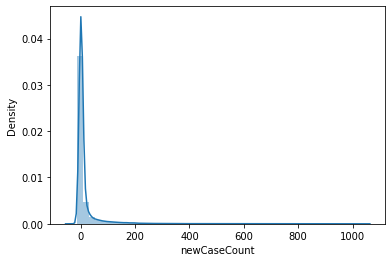

In [47]:
sns.distplot(covidDataFrame.newCaseCount)

c:\users\jfizzle\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tempSingleMean', ylabel='Density'>

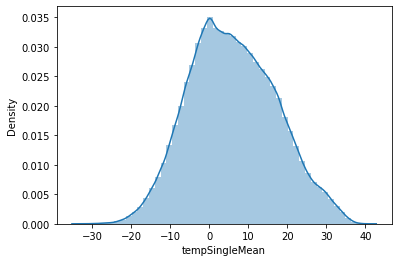

In [48]:
sns.distplot(temperatureDataFrame.tempSingleMean)

## Preprocessing

#### Flatten Frames

In [3]:
flattenedCovidDataFrame = pd.json_normalize(json.load(open(Path('../data/covid_county.Colorado/data.json'))))
flattenedCovidGeometryFrame = pd.json_normalize(json.load(open(Path('../data/covid_county.Colorado/linkedGeometry.json'))))

flattenedWindDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_2d_wind.Colorado/data.json'))))
flattenedWindGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_2d_wind.Colorado/linkedGeometry.json'))))

# flattenedPressureDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_barometric_pressure.Colorado/data.json'))))
# flattenedPressureGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_barometric_pressure.Colorado/linkedGeometry.json'))))
#
# flattenedTemperatureDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_single_asp_air_temperature.Colorado/data.json'))))
# flattenedTemperatureGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_single_asp_air_temperature.Colorado/linkedGeometry.json'))))
#
# flattenedPopulationDataFrame = pd.json_normalize(json.load(open(Path('../data/county_total_population.Colorado/data.json'))))
# flattenedPopulationGeometryFrame = pd.json_normalize(json.load(open(Path('../data/county_total_population.Colorado/linkedGeometry.json'))))

#### Join Data and Geometry

In [4]:
combinedCovidFrame = flattenedCovidDataFrame.set_index('GISJOIN').join(flattenedCovidGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')
combinedWindFrame = flattenedWindDataFrame.set_index('site').join(flattenedWindGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
# combinedPressureFrame = flattenedPressureDataFrame.set_index('site').join(flattenedPressureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
# combinedTemperatureFrame = flattenedTemperatureDataFrame.set_index('site').join(flattenedTemperatureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
# combinedPopulationFrame = flattenedPopulationDataFrame.set_index('GISJOIN').join(flattenedPopulationGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')

#### Generalize Geometry

In [22]:

def create_county_polygons(combinedCovidFrame):
    county_polygons = []
    df = combinedCovidFrame.groupby('county').first().reindex(columns=['coordJsonString', 'geometry.type', "geometry.coordinates"])
    print(df)
    df['coordJsonString'] = df["geometry.coordinates"].apply(json.dumps)
    for index, row in df[['coordJsonString', 'geometry.type']].iterrows():
        print(f"processing: {index}")
        shape_data = json.loads(row['coordJsonString'])
        county = index
        if row['geometry.type'] == 'MultiPolygon':
            for p in shape_data:
                s = np.asarray(p)[0]
                shape = Polygon(*s)
                county_polygons.append((county, shape))
        elif row['geometry.type'] == 'Polygon':
            s = np.asarray(shape_data)[0]
            shape = Polygon(*s)
            county_polygons.append((county, shape))
        else:
            print(f"Row had geometry type of {row['geometry.type']}, row is {row}")
    return county_polygons
#
county_polygons = create_county_polygons(combinedCovidFrame)

                                              coordJsonString geometry.type  \
county                                                                        
Adams       [[[-104.96140800028297, 40.00033699940714], [-...       Polygon   
Alamosa     [[[-105.45725500006058, 37.75146400032936], [-...       Polygon   
Arapahoe    [[[[-104.93042900099888, 39.66755700030373], [...  MultiPolygon   
Archuleta   [[[-107.1286799987523, 37.42294200083849], [-1...       Polygon   
Baca        [[[-102.747614999905, 37.64364200060204], [-10...       Polygon   
...                                                       ...           ...   
Summit      [[[-105.92461799963675, 39.69897200037548], [-...       Polygon   
Teller      [[[-105.32922000017577, 39.12968899909268], [-...       Polygon   
Washington  [[[-102.77995999963086, 40.43844599984182], [-...       Polygon   
Weld        [[[[-104.97304400029685, 40.032751999519604], ...  MultiPolygon   
Yuma        [[[-102.66480400059046, 40.4384730001580

C:\Users\Jfizzle\AppData\Local\Temp/ipykernel_1124/1820218632.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  s = np.asarray(p)[0]


In [27]:
# Test points in multipolygons:

broomfield = Point(-105.155050, 39.902027)
araphoe_a = Point(-104.938059, 39.708506)
araphoe_b = Point(-104.645945, 39.672519)
for point in [broomfield, araphoe_a, araphoe_b]:
    for county, shape in county_polygons:
        if shape.encloses_point(point):
            print(f"point is in {county}")
            break

location = np.asarray(combinedWindFrame.iloc[1]["geometry.coordinates"])
point = Point(location)
for county, shape in county_polygons:
    if shape.encloses_point(point):
        print(f"point is in {county}")

point is in Broomfield
point is in Arapahoe
point is in Arapahoe
point is in Yuma


## References

## About this Notebook

**Authors:** Kyle Bassignani, Jeff Borgerson, and Christian Westbrook  
**Updated On:** 2021-11-20